In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from sklearn.model_selection import train_test_split

import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [48]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [49]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((.5,.5,.5), (.5,.5,5))
])
train_data = torchvision.datasets.CIFAR10(root="cifar10", download=True, train=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root="cifar10", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [72]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, padding=1, stride=2), # output size: (32+2*1-4)/2 + 1 = 16
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=4, padding=1, stride=2), # output size: (16+2*1-4)/2 + 1 = 8
            nn.LeakyReLU(),
        )

        self.latent = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2), # output size: (8+2*1-4)/2 + 1 = 4
            nn.LeakyReLU()
        )

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2), # output size: (4-1)*2 - 2*1 + 4 = 8
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, padding=1, stride=2), # output size: (8-1)*2 - 2*1 + 4 = 16
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, padding=1, stride=2), # output size: (16-1)*2 - 2*1 + 4 = 32
            nn.LeakyReLU()
        )
    
    def forward(self, x):
        # x = self.enc(x)
        # print('Enc size: ', x.shape)
        # x = self.latent(x)
        # print('Latent size: ', x.shape)
        # x = self.dec(x)
        # print('Dec size: ', x.shape)
        # return x
        return self.dec(self.latent(self.enc(x)))

In [52]:
def getModel():

    CNN = Model()

    lossFunction = nn.MSELoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [73]:
# test model
CNN, lossFunction, optimizer = getModel()

X, y = next(iter(train_loader))
yHat = CNN(X)


# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossFunction(yHat,X)
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 3, 32, 32])
 
Loss:
tensor(0.1748, grad_fn=<MseLossBackward0>)


In [68]:
def trainModel(CNN, lossFunction, optimizer):

    epochs = 10

    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)

    CNN.to(device)

    for _ in range(epochs):
        print(' ')    
        print("Epoch: ", _)

        CNN.train()

        batchLoss = []

        for X, _1 in train_loader:

            X = X.to(device)

            yHat = CNN(X)

            loss = lossFunction(yHat, X) # using original image to compare as this is an Autoencoder

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[_] = np.mean(batchLoss)

        CNN.eval()

        X, _2 = next(iter(test_loader))

        X = X.to(device)

        with torch.no_grad():
            pred = CNN(X)
            loss = lossFunction(pred, X)

        pred = pred.cpu()

        testLoss[_] = loss.item()

    return trainLoss, testLoss, CNN

In [74]:
CNN, lossFunction, optimizer = getModel()
trainLoss, testLoss, CNN = trainModel(CNN, lossFunction, optimizer)

 
Epoch:  0
 
Epoch:  1
 
Epoch:  2
 
Epoch:  3
 
Epoch:  4
 
Epoch:  5
 
Epoch:  6
 
Epoch:  7
 
Epoch:  8
 
Epoch:  9


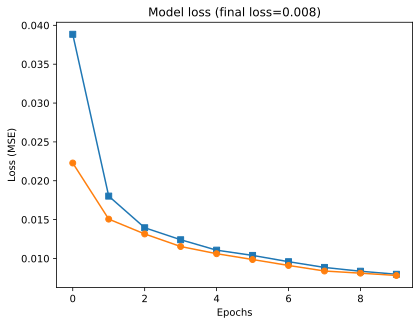

In [75]:
plt.plot(trainLoss, 's-', label='Train')
plt.plot(testLoss, 'o-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%testLoss[-1])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


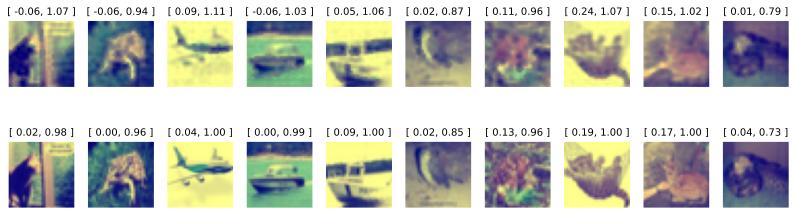

In [79]:
## show some random examples

# get some data
X,y = next(iter(test_loader))

# forward pass and loss
CNN.cpu()
CNN.eval() # switch to test mode
yHat = CNN(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  image2pic = np.random.randint(0,10000)
  pic = yHat[image2pic,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[image2pic,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

  
plt.show()